# **OFDM: IMPLEMENTAÇÃO VIA IFFT**

A multiplexação por divisão de frequências ortogonais, ou OFDM, é uma técnica de modulação de dados que por diversas características, é apropriada à tecnologia de rádios cognitivos. OFDM é uma técnica de  transmissão de dados que utiliza sua banda dividida em múltiplas portadoras ortogonais, chamadas subportadoras, para modulação. As subportadora são chamadas ortogonais por não possuírem sobreposição de frequência, dessa forma não interferindo umas com as outras.

![](../Imagens/Unidade3/ofdm.jpg)

In [1]:
# Bibliotecas padrão 
import numpy as np
import matplotlib.pyplot as plt

## **ETAPA 0 - Características Fundamentais do Sistema OFDM**


In [2]:
# Parâmetros
USE_WARPLAB_TXRX= 0           # Enable WARPLab-in-the-loop (otherwise sim-only)
WRITE_PNG_FILES = 0           # Enable writing plots to PNG
CHANNEL= 11                   # Channel to tune Tx and Rx radios

# Waveform params
N_OFDM_SYMS = 95              # Number of OFDM symbols
MOD_ORDER = 2                 # Modulation order (2/4/16/64 = BSPK/QPSK/16-QAM/64-QAM)
TX_SCALE = 1.0                # Scale for Tx waveform ([0:1])

# OFDM params
N_SC = 128                    # Number of OFDM subcarriers
CP_LEN = N_SC // 4            # Length of the cyclic prefix: 25% of the block
P = N_SC // 16                # Number of pilot carriers per OFDM block

In [3]:
# Configurações 
AllCarriers = np.arange(N_SC)            # [1, 2, 3, ..., K-1 ,K]
PilotCarriers = AllCarriers[::N_SC//P]   # [K/P, 2K/P, 3K/P, ..., (K-1)*K/P]
PilotCarriers = np.hstack([PilotCarriers, np.array([AllCarriers[-1]])]) # Make the last carriers also be a pilot
P = P + 1                                # Add one to the number of pilots to account for the DC carrier
DataCarriers = np.delete(AllCarriers, PilotCarriers) # Data carriers are all remaining carriers
PilotValue = 7 + 7j                      # The known value each pilot transmits

## Visualizando

All Carriers: 
 [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127]
Pilot Carriers: 
 [  0  16  32  48  64  80  96 112 127]
Data Carriers: 
 [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  17  18  19
  20  21  22  23  24  25  26  27  28  29  30  31  33  34  35  36  37  38
  39  40  41  42  43  44  45  46  47  49  50  51  52  53  54  55  56  57
  58  59  60  61  62  63  65  66  67  68  69  70  71  72  73  74  75  76
  77  78  79  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95
  97  98  99 100 101 102 

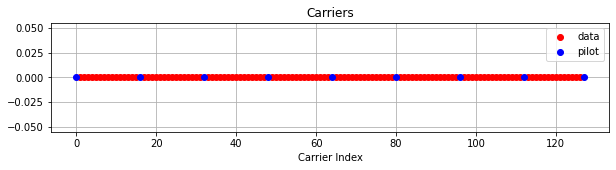

In [4]:
# Prints
print("All Carriers: \n", AllCarriers)
print("Pilot Carriers: \n", PilotCarriers)
print("Data Carriers: \n", DataCarriers)

# Plots
plt.figure(figsize=(10, 2))
plt.plot(DataCarriers, np.zeros_like(DataCarriers), 'ro', label='data')
plt.plot(PilotCarriers, np.zeros_like(PilotCarriers), 'bo', label='pilot')
plt.title('Carriers')
plt.xlabel('Carrier Index')
plt.legend()
plt.grid()

# Show Image
plt.show()

## **Modulação 64-QAM**

In [5]:
mu = 6                                       # bits per symbol (64-QAM)
payloadBits_per_OFDM = len(DataCarriers)*mu  # number of payload bits per OFDM symbol
print('payloadBits per OFDM: \n', payloadBits_per_OFDM)

# 64-QAM Modulation MAP
mapping_table = {
(0,0,0,0,0,0) : +7+7j, (0,0,0,0,0,1) : +5+7j,
(0,0,0,0,1,0) : +1+7j, (0,0,0,0,1,1) : +3+7j,
(0,0,0,1,0,0) : -7+7j, (0,0,0,1,0,1) : -5+7j,
(0,0,0,1,1,0) : -1+7j, (0,0,0,1,1,1) : -3+7j,
(0,0,1,0,0,0) : +7+5j, (0,0,1,0,0,1) : +5+5j,
(0,0,1,0,1,0) : +1+5j, (0,0,1,0,1,1) : +3+5j,
(0,0,1,1,0,0) : -7+5j, (0,0,1,1,0,1) : -5+5j,
(0,0,1,1,1,0) : -1+5j, (0,0,1,1,1,1) : -3+5j,
(0,1,0,0,0,0) : +7+1j, (0,1,0,0,0,1) : +5+1j,
(0,1,0,0,1,0) : +1+1j, (0,1,0,0,1,1) : +3+1j,
(0,1,0,1,0,0) : -7+1j, (0,1,0,1,0,1) : -5+1j,
(0,1,0,1,1,0) : -1+1j, (0,1,0,1,1,1) : -3+1j,
(0,1,1,0,0,0) : +7+3j, (0,1,1,0,0,1) : +5+3j,
(0,1,1,0,1,0) : +1+3j, (0,1,1,0,1,1) : +3+3j,
(0,1,1,1,0,0) : -7+3j, (0,1,1,1,0,1) : -5+3j,
(0,1,1,1,1,0) : -1+3j, (0,1,1,1,1,1) : -3+3j,
(1,0,0,0,0,0) : +7-7j, (1,0,0,0,0,1) : +5-7j,
(1,0,0,0,1,0) : +1-7j, (1,0,0,0,1,1) : +3-7j,
(1,0,0,1,0,0) : -7-7j, (1,0,0,1,0,1) : -5-7j,
(1,0,0,1,1,0) : -1-7j, (1,0,0,1,1,1) : -3-7j,
(1,0,1,0,0,0) : +7-5j, (1,0,1,0,0,1) : +5-5j,
(1,0,1,0,1,0) : +1-5j, (1,0,1,0,1,1) : +3-5j,
(1,0,1,1,0,0) : -7-5j, (1,0,1,1,0,1) : -5-5j,
(1,0,1,1,1,0) : -1-5j, (1,0,1,1,1,1) : -3-5j,
(1,1,0,0,0,0) : +7-1j, (1,1,0,0,0,1) : +5-1j,
(1,1,0,0,1,0) : +1-1j, (1,1,0,0,1,1) : +3-1j,
(1,1,0,1,0,0) : -7-1j, (1,1,0,1,0,1) : -5-1j,
(1,1,0,1,1,0) : -1-1j, (1,1,0,1,1,1) : -3-1j,
(1,1,1,0,0,0) : +7-3j, (1,1,1,0,0,1) : +5-3j,
(1,1,1,0,1,0) : +1-3j, (1,1,1,0,1,1) : +3-3j,
(1,1,1,1,0,0) : -7-3j, (1,1,1,1,0,1) : -5-3j,
(1,1,1,1,1,0) : -1-3j, (1,1,1,1,1,1) : -3-3j
}

payloadBits per OFDM: 
 714


## Visualizando

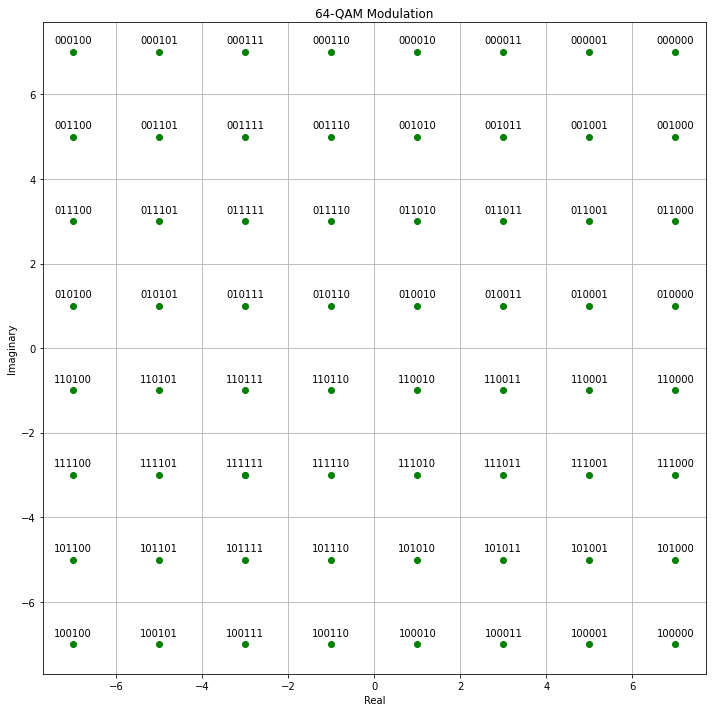

In [6]:
# Visualiza o mapa de constelação QAM

plt.figure(1, figsize=(10, 10))

for b5 in [0, 1]:
 for b4 in [0, 1]:
  for b3 in [0, 1]:
   for b2 in [0, 1]:
    for b1 in [0, 1]:
      for b0 in [0, 1]:
          B = (b5, b4, b3, b2, b1, b0)
          Q = mapping_table[B]
          plt.plot(Q.real, Q.imag, 'go')
          plt.text(Q.real, Q.imag+0.2, "".join(str(x) for x in B), ha='center')

plt.title('64-QAM Modulation')
plt.xlabel('Real')
plt.ylabel('Imaginary')
plt.plot(Q.real, Q.imag, 'go')
plt.grid(True)
plt.tight_layout()
plt.show()

## **Demodulador**

In [7]:
demapping_table = {v : k for k, v in mapping_table.items()}

## Visualizando

In [8]:
# Realiza a demoulação do sinal
QAMreciver = [
    -1-7j,
    +7-5j,
    +1-5j,
    +1-1j
]

# Realiza a demoulação do sinal
demappingQAM = [demapping_table[q] for q in QAMreciver]

# Printa os resultados
print("Demapping QAM:", demappingQAM)


Demapping QAM: [(1, 0, 0, 1, 1, 0), (1, 0, 1, 0, 0, 0), (1, 0, 1, 0, 1, 0), (1, 1, 0, 0, 1, 0)]


## **Subcarrier index**

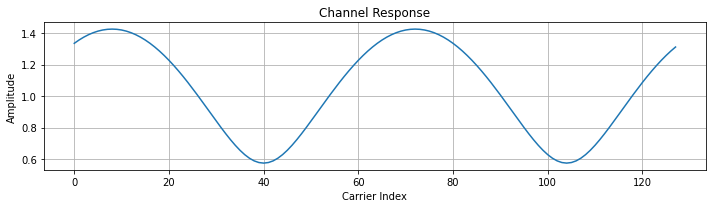

In [9]:
channelResponse = np.array([1, 0, 0.3+0.3j])  # the impulse response of the wireless channel
H_exact = np.fft.fft(channelResponse, N_SC)

plt.figure(1, figsize=(10, 3))
plt.plot(AllCarriers, abs(H_exact))
plt.title('Channel Response')
plt.xlabel('Carrier Index')
plt.ylabel('Amplitude')
plt.grid()


plt.tight_layout()
plt.show()

# **Criação de Bits Aleatórios**

In [10]:
# Gerando Bits conforme uma distribuição binomial de probabilidade 0.5.
bits = np.random.binomial(n=1, p=0.5, size=(payloadBits_per_OFDM))
print ("Bits count: \n", len(bits))
print ("First 20 bits: \n", bits[:64])
print ("Mean of bits (should be around 0.5): \n", np.mean(bits))

# Formata os dados para o formato do QAM
def SP(bits):
  return bits.reshape((len(DataCarriers), mu))

bits_SP = SP(bits)
print ("\n16 bit groups\n")
print (bits_SP[:16,:])

Bits count: 
 714
First 20 bits: 
 [1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 1 0 1 1 0 0 0 1 0 1 1 1 1 0 1
 0 0 1 0 1 1 1 1 0 1 1 0 0 0 0 1 0 0 0 0 0 0 1 1 1 1 1]
Mean of bits (should be around 0.5): 
 0.47619047619047616

16 bit groups

[[1 0 0 0 0 1]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [1 1 0 0 1 0]
 [1 1 0 0 0 1]
 [0 1 1 1 1 0]
 [1 0 0 1 0 1]
 [1 1 1 0 1 1]
 [0 0 0 0 1 0]
 [0 0 0 0 0 1]
 [1 1 1 1 0 1]
 [0 1 1 0 0 1]
 [0 0 0 1 0 0]
 [0 1 1 0 0 1]
 [1 0 1 0 0 1]
 [1 1 1 0 0 0]]


In [11]:
# Realiza a modulação do sinal - > Bits to 64-QAM
def Mapping(bits):
  return np.array([mapping_table[tuple(b)] for b in bits])

# Realiza a demoulação do sinal
QAM = Mapping(bits_SP)
print ("First 16 QAM symbols and bits:")
print (bits_SP[:16,:], '\n')
print ("Conversão para números complexos: \n", QAM[:16])

# Demodulação do sinal
demapping_table = {v : k for k, v in mapping_table.items()}

First 16 QAM symbols and bits:
[[1 0 0 0 0 1]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [1 1 0 0 1 0]
 [1 1 0 0 0 1]
 [0 1 1 1 1 0]
 [1 0 0 1 0 1]
 [1 1 1 0 1 1]
 [0 0 0 0 1 0]
 [0 0 0 0 0 1]
 [1 1 1 1 0 1]
 [0 1 1 0 0 1]
 [0 0 0 1 0 0]
 [0 1 1 0 0 1]
 [1 0 1 0 0 1]
 [1 1 1 0 0 0]] 

Conversão para números complexos: 
 [ 5.-7.j  7.+7.j  7.+7.j  1.-1.j  5.-1.j -1.+3.j -5.-7.j  3.-3.j  1.+7.j
  5.+7.j -5.-3.j  5.+3.j -7.+7.j  5.+3.j  5.-5.j  7.-3.j]


Number of OFDM carriers in frequency domain:  128
First 20 OFDM symbols: 
 [ 7.+7.j  5.-7.j  7.+7.j  7.+7.j  1.-1.j  5.-1.j -1.+3.j -5.-7.j  3.-3.j
  1.+7.j  5.+7.j -5.-3.j  5.+3.j -7.+7.j  5.+3.j  5.-5.j  7.+7.j  7.-3.j
 -1.-1.j -7.+5.j]


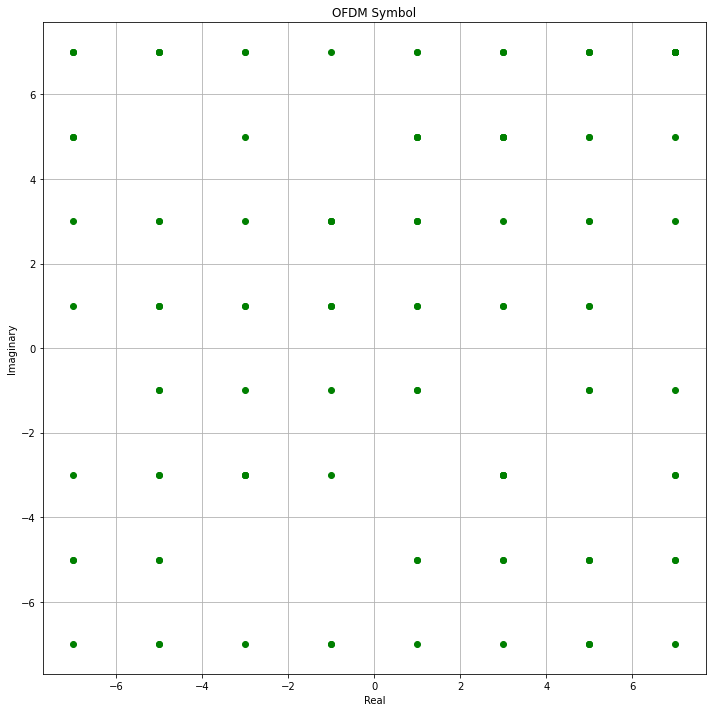

In [12]:
def OFDM_symbol(QAM_payload):
  symbol = np.zeros(N_SC, dtype=complex) # The overall N_SC subcarriers
  symbol[PilotCarriers] = PilotValue     # Allocate the pilot subcarriers 
  symbol[DataCarriers] = QAM_payload     # Allocate the pilot subcarriers
  return symbol

OFDM_data = OFDM_symbol(QAM)
print ("Number of OFDM carriers in frequency domain: ", len(OFDM_data))
print("First 20 OFDM symbols: \n", OFDM_data[:20])

# Plota a constelação de números complexos OFDM_data
plt.figure(1, figsize=(10, 10))
plt.plot(OFDM_data.real, OFDM_data.imag, 'go')
plt.title('OFDM Symbol')
plt.xlabel('Real')
plt.ylabel('Imaginary')
plt.grid()

plt.tight_layout()
plt.show()

# **Realizando a IFFT**

Number of OFDM samples in time-domain before CP:  128
First 20 OFDM time samples: 
 [ 0.78125   +1.3125j     -0.26127818+0.29301212j  0.45733731+0.27190825j
 -0.19087388+0.73991504j  0.68713619+0.03073079j  0.83181855-0.21328278j
 -0.07464342+0.50363561j  0.48535256-0.05028036j  0.83302528-0.41423645j
  0.21302972+0.09006025j  0.20636379+0.28496309j -0.15722214+0.46573253j
 -0.27279671-0.42016314j -0.40083804+0.79976969j  0.07420408-0.1337463j
 -0.25082098+0.27695242j  0.22489685+0.47378641j  0.48092859-0.57934705j
 -0.06844514+0.16571846j  0.14098284+0.34177963j]


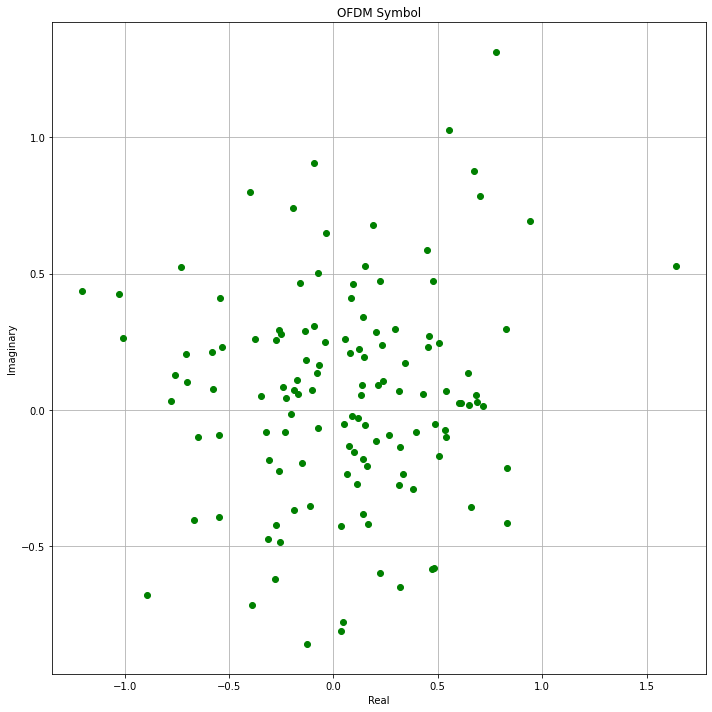

In [14]:
def IFFT(OFDM_data):
  return np.fft.ifft(OFDM_data)

OFDM_time = IFFT(OFDM_data)
print ("Number of OFDM samples in time-domain before CP: ", len(OFDM_time))
print("First 20 OFDM time samples: \n", OFDM_time[:20])

# Plota a constelação de números complexos OFDM time
plt.figure(1, figsize=(10, 10))
plt.plot(OFDM_time.real, OFDM_time.imag, 'go')
plt.title('OFDM Symbol')
plt.xlabel('Real')
plt.ylabel('Imaginary')
plt.grid()

plt.tight_layout()
plt.show()

# **IFFT Com Prefixo Cíclico**

Number of OFDM samples in time domain with CP:  160
First 20 OFDM samples with CP: 
 [ 0.828125  +0.296875j    0.03781388-0.8109609j   0.11738571-0.02871021j
 -0.30802762-0.18229764j -0.54432043+0.40892264j -0.77804646+0.03165358j
 -0.18654831+0.07371997j -0.34845622+0.05194181j  0.93989771+0.69211474j
 -1.02851558+0.42418549j -0.54751016-0.09055978j  0.6431217 +0.13620499j
 -0.72759872+0.52286058j  0.53823726-0.09776138j  0.06676458-0.23647599j
  0.31980809-0.64963658j  0.07779976+0.20770146j  0.5063062 -0.16943461j
  0.53907709+0.070184j    0.13357981+0.05440867j]


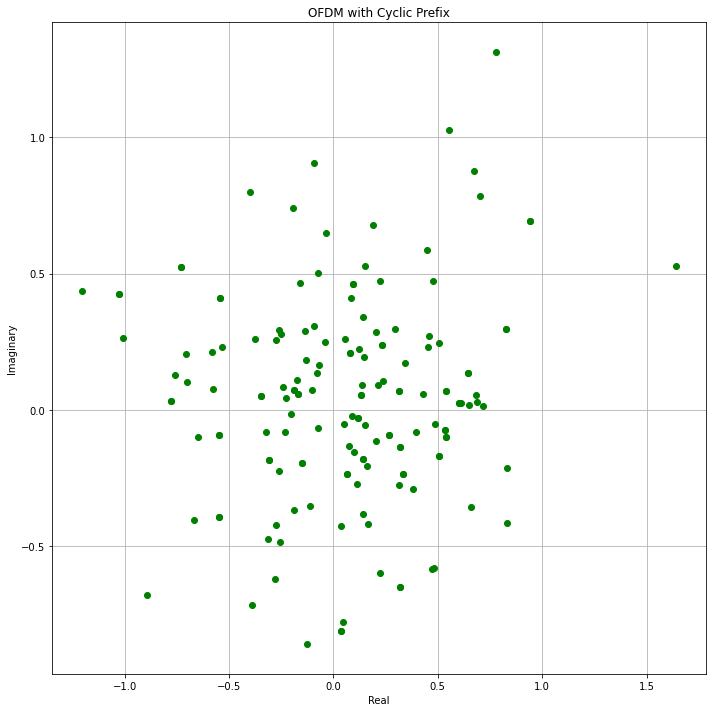

In [15]:
# Add cyclic prefix
def addCP(OFDM_time):
  cp = OFDM_time[-CP_LEN:]               # take the last CP samples ...
  return np.hstack([cp, OFDM_time])      # ... and add them to the beginning

OFDM_withCP = addCP(OFDM_time)
print ("Number of OFDM samples in time domain with CP: ", len(OFDM_withCP))
print("First 20 OFDM samples with CP: \n", OFDM_withCP[:20])

# Plota a constelação de números complexos OFDM_withCP
plt.figure(1, figsize=(10, 10))
plt.plot(OFDM_withCP.real, OFDM_withCP.imag, 'go')
plt.title('OFDM with Cyclic Prefix')
plt.xlabel('Real')
plt.ylabel('Imaginary')
plt.grid()

plt.tight_layout()
plt.show()

# **Realizando a criação de um filtro FIR (-80 dB)**

In [17]:
attenuation = 80                # dB
transition_width = 0.08 * np.pi # frequency transition width
w_c = 0.6 * np.pi               # cut frequency

### **Retangular**

In [18]:
def return_n_rect(transition_width):
    return int(np.ceil(0.9 / transition_width))

print("N_rect: ", return_n_rect(transition_width))

N_rect:  4


### **Hanning**

In [19]:
def return_n_han(transition_width):
    return int(np.ceil(3.1 / transition_width))

print("N_han: ", return_n_han(transition_width))

N_han:  13


### **Hamming**

In [20]:
def return_n_ham(transition_width):
    return int(np.ceil(3.3 / transition_width))

print("N_ham: ", return_n_ham(transition_width))

N_ham:  14


### **Blackman**

In [21]:
def return_n_blc(transition_width):
    return int(np.ceil(5.5 / transition_width))

print("N_blc: ", return_n_blc(transition_width))

N_blc:  22


### **Kaiser**

In [22]:
# Retora o valor de beta para janela de Kaiser
def retorna_beta(att):
    if att >= 50:
        return 0.1102*(att-8.7)
    if 21 < att < 50:
        return 0.5842*(att-21.0) ** (0.4) +0.07886*(att-21.0)
    if att <= 21:
        return 0

# Retora o valor de N para janela de Kaiser
def return_n_kai(att, delta_w):
    return int(np.ceil((att-8)/(2.285 * delta_w)))

print(retorna_beta(attenuation))
print(return_n_kai(attenuation, transition_width))

7.85726
126


### Visualizando:


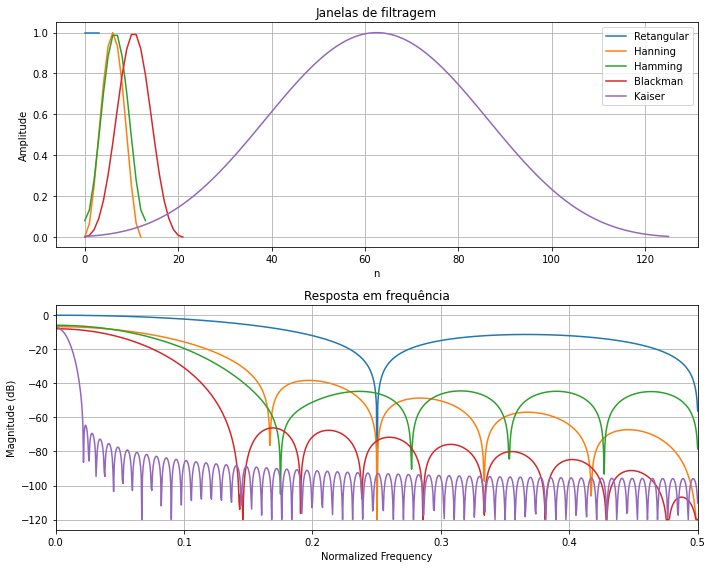

In [23]:
# Importando as bibliotecas padrão
import numpy as np
import matplotlib.pyplot as plt

# Criando as janelas de filtragem
janela_retangular = np.ones(return_n_rect(transition_width))
janela_hanning = np.hanning(return_n_han(transition_width))
janela_hamming = np.hamming(return_n_ham(transition_width))
janela_blackman = np.blackman(return_n_blc(transition_width))
janela_kaiser = np.kaiser(return_n_kai(attenuation, transition_width), retorna_beta(attenuation))

# FFT das Janelas
retanular_freq = np.fft.fft(janela_retangular, 2048) / len(janela_retangular)
hanning_freq = np.fft.fft(janela_hanning, 2048) / len(janela_hanning)
hamming_freq = np.fft.fft(janela_hamming, 2048) / len(janela_hamming)
blackman_freq = np.fft.fft(janela_blackman, 2048) / len(janela_blackman)
kaiser_freq = np.fft.fft(janela_kaiser, 2048) / len(janela_kaiser)

# Espectro de magnitude
mag_retanular = np.abs(np.fft.fftshift(retanular_freq))
mag_hanning = np.abs(np.fft.fftshift(hanning_freq))
mag_hamming = np.abs(np.fft.fftshift(hamming_freq))
mag_blackman = np.abs(np.fft.fftshift(blackman_freq))
mag_kaiser = np.abs(np.fft.fftshift(kaiser_freq))

# Normalizando o espectro de magnitude
with np.errstate(divide='ignore', invalid='ignore'):
    response_retanular = 20 * np.log10(mag_retanular)
    response_hanning = 20 * np.log10(mag_hanning)
    response_hamming = 20 * np.log10(mag_hamming)
    response_blackman = 20 * np.log10(mag_blackman)
    response_kaiser = 20 * np.log10(mag_kaiser)

# Clipando para excluir valores menores que 100 dB
response_retanular = np.clip(response_retanular, -120, 100)
response_hanning = np.clip(response_hanning, -120, 100)
response_hamming = np.clip(response_hamming, -120, 100)
response_blackman = np.clip(response_blackman, -120, 100)
response_kaiser = np.clip(response_kaiser, -120, 100)

plt.figure(1, figsize=(10, 8))
# Plotando o sinal de onda senoidal
plt.subplot(2, 1, 1)
# Plota as janelas de filtragem
plt.plot(janela_retangular, label='Retangular')
plt.plot(janela_hanning, label='Hanning')
plt.plot(janela_hamming, label='Hamming')
plt.plot(janela_blackman, label='Blackman')
plt.plot(janela_kaiser, label='Kaiser')
plt.title('Janelas de filtragem')
plt.xlabel('n')
plt.ylabel('Amplitude')
plt.legend()
plt.grid()

# Plotando a resposta em frequência
plt.subplot(2, 1, 2)
plt.plot(np.linspace(-.5, .5, len(response_retanular)), response_retanular, label='Retangular')
plt.plot(np.linspace(-.5, .5, len(response_hanning)), response_hanning, label='Hanning')
plt.plot(np.linspace(-.5, .5, len(response_hamming)),response_hamming, label='Hamming')
plt.plot(np.linspace(-.5, .5, len(response_blackman)),response_blackman, label='Blackman')
plt.plot(np.linspace(-.5, .5, len(response_kaiser)),response_kaiser, label='Kaiser')
plt.title('Resposta em frequência')
plt.xlabel('Normalized Frequency')
plt.ylabel('Magnitude (dB)')
plt.xlim(0, 0.5)
plt.grid()

plt.tight_layout()
plt.show()

### Código FIR:

In [24]:
def h_indeal(f_corte:float, N:int)->np.ndarray:
    # Função que calcula o H_ideal (OBS: Divisão por zero!)
        return np.sin(f_corte*(np.arange(N) - N/(2.001)))/(np.pi*(np.arange(N) - N/2.0008))

def fir_rectangular():
    return h_indeal(w_c, return_n_rect(transition_width)) * janela_retangular

def fir_hanning():
    return h_indeal(w_c, return_n_han(transition_width)) * janela_hanning

def fir_hamming():
    return h_indeal(w_c, return_n_ham(transition_width)) * janela_hamming

def fir_blackman():
    return h_indeal(w_c, return_n_blc(transition_width)) * janela_blackman

def fir_kaiser():
    return h_indeal(w_c, return_n_kai(attenuation, transition_width)) * janela_kaiser


### Visualiza H Ideal:


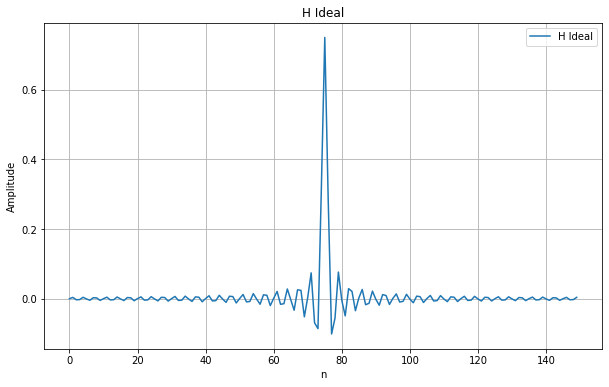

In [25]:
#Plota o H Ideal
plt.figure(2, figsize=(10, 6))
plt.plot(h_indeal(w_c, 150), label='H Ideal')
plt.title('H Ideal')
plt.xlabel('n')
plt.ylabel('Amplitude')
plt.legend()
plt.grid()
plt.show()

### Visualizando:

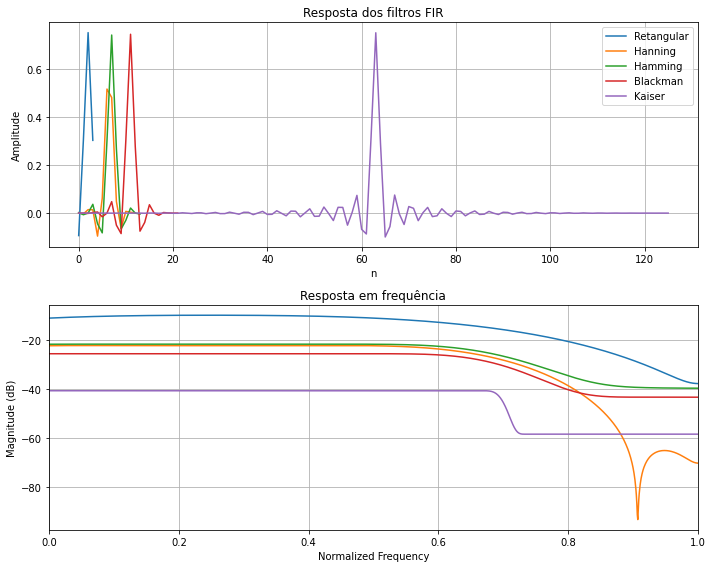

In [26]:
# FFT das Janelas
retanular_freq = np.fft.fft(fir_rectangular(), 2048) / len(fir_rectangular())
hanning_freq = np.fft.fft(fir_hanning(), 2048) / len(fir_hanning())
hamming_freq = np.fft.fft(fir_hamming(), 2048) / len(fir_hamming())
blackman_freq = np.fft.fft(fir_blackman(), 2048) / len(fir_blackman())
kaiser_freq = np.fft.fft(fir_kaiser(), 2048) / len(fir_kaiser())

# Espectro de magnitude
mag_retanular = np.abs(np.fft.fftshift(retanular_freq))
mag_hanning = np.abs(np.fft.fftshift(hanning_freq))
mag_hamming = np.abs(np.fft.fftshift(hamming_freq))
mag_blackman = np.abs(np.fft.fftshift(blackman_freq))
mag_kaiser = np.abs(np.fft.fftshift(kaiser_freq))

# Normalizando o espectro de magnitude
with np.errstate(divide='ignore', invalid='ignore'):
    response_retanular = 20 * np.log10(mag_retanular)
    response_hanning = 20 * np.log10(mag_hanning)
    response_hamming = 20 * np.log10(mag_hamming)
    response_blackman = 20 * np.log10(mag_blackman)
    response_kaiser = 20 * np.log10(mag_kaiser)

# Clipando para excluir valores menores que 100 dB
response_retanular = np.clip(response_retanular, -120, 100)
response_hanning = np.clip(response_hanning, -120, 100)
response_hamming = np.clip(response_hamming, -120, 100)
response_blackman = np.clip(response_blackman, -120, 100)
response_kaiser = np.clip(response_kaiser, -120, 100)

# Plota os Filtros FIR de cada janela
plt.figure(2, figsize=(10, 8))

plt.subplot(2, 1, 1)
plt.plot(fir_rectangular(), label='Retangular')
plt.plot(fir_hanning(), label='Hanning')
plt.plot(fir_hamming(), label='Hamming')
plt.plot(fir_blackman(), label='Blackman')
plt.plot(fir_kaiser(), label='Kaiser')
plt.title('Resposta dos filtros FIR')
plt.xlabel('n')
plt.ylabel('Amplitude')
plt.legend()
plt.grid()

# Plota o espectro de magnitude dos filtros FIR
plt.subplot(2, 1, 2)
plt.plot(np.linspace(-.5, 1, len(response_retanular)), response_retanular, label='Retangular')
plt.plot(np.linspace(-.5, 1, len(response_hanning)), response_hanning, label='Hanning')
plt.plot(np.linspace(-.5, 1, len(response_hamming)), response_hamming, label='Hamming')
plt.plot(np.linspace(-.5, 1, len(response_blackman)), response_blackman, label='Blackman')
plt.plot(np.linspace(-.5, 1, len(response_kaiser)), response_kaiser, label='Kaiser')
plt.title('Resposta em frequência')
plt.xlabel('Normalized Frequency')
plt.ylabel('Magnitude (dB)')
plt.xlim(0, 1)
plt.grid()

plt.tight_layout()
plt.show()

# **Implementa os Filtros FIR no OFDM**

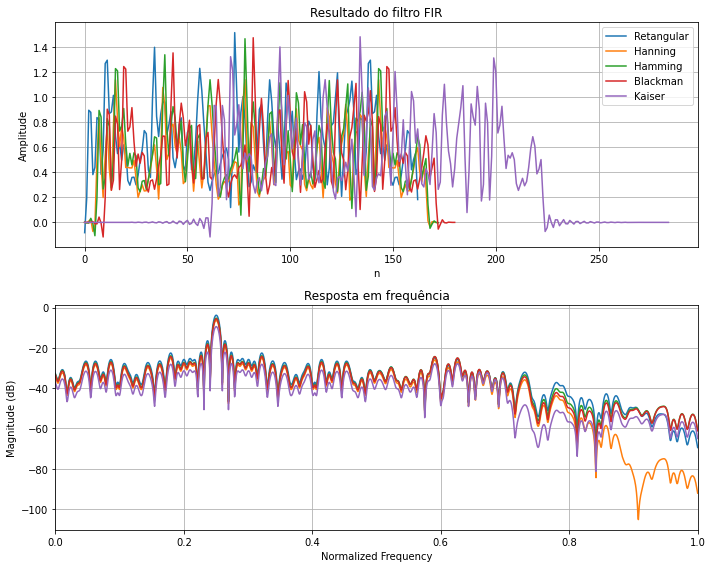

In [27]:
resultado_retanular = np.convolve(abs(OFDM_withCP), fir_rectangular())
resultado_hanning = np.convolve(  abs(OFDM_withCP), fir_hanning())
resultado_hamming = np.convolve(  abs(OFDM_withCP), fir_hamming())
resultado_blackman = np.convolve( abs(OFDM_withCP), fir_blackman())
resultado_kaiser = np.convolve(   abs(OFDM_withCP), fir_kaiser())

# FFT do resultado
retanular_freq = np.fft.fft(resultado_retanular, 2048) / len(resultado_retanular)
hanning_freq = np.fft.fft(resultado_hanning, 2048) / len(resultado_hanning)
hamming_freq = np.fft.fft(resultado_hamming, 2048) / len(resultado_hamming)
blackman_freq = np.fft.fft(resultado_blackman, 2048) / len(resultado_blackman)
kaiser_freq = np.fft.fft(resultado_kaiser, 2048) / len(resultado_kaiser)

# Espectro de magnitude
mag_retanular = np.abs(np.fft.fftshift(retanular_freq))
mag_hanning = np.abs(np.fft.fftshift(hanning_freq))
mag_hamming = np.abs(np.fft.fftshift(hamming_freq))
mag_blackman = np.abs(np.fft.fftshift(blackman_freq))
mag_kaiser = np.abs(np.fft.fftshift(kaiser_freq))

# Normalizando o espectro de magnitude
with np.errstate(divide='ignore', invalid='ignore'):
    response_retanular = 20 * np.log10(mag_retanular)
    response_hanning = 20 * np.log10(mag_hanning)
    response_hamming = 20 * np.log10(mag_hamming)
    response_blackman = 20 * np.log10(mag_blackman)
    response_kaiser = 20 * np.log10(mag_kaiser)

# Clipando para excluir valores menores que 120 dB
response_retanular = np.clip(response_retanular, -120, 100)
response_hanning = np.clip(response_hanning, -120, 100)
response_hamming = np.clip(response_hamming, -120, 100)
response_blackman = np.clip(response_blackman, -120, 100)
response_kaiser = np.clip(response_kaiser, -120, 100)


# Plota o resultado do filtro FIR
plt.figure(3, figsize=(10, 8))
plt.subplot(2, 1, 1)
plt.plot(resultado_retanular, label='Retangular')
plt.plot(resultado_hanning, label='Hanning')
plt.plot(resultado_hamming, label='Hamming')
plt.plot(resultado_blackman, label='Blackman')
plt.plot(resultado_kaiser, label='Kaiser')
plt.title('Resultado do filtro FIR')
plt.xlabel('n')
plt.ylabel('Amplitude')
plt.legend()
plt.grid()

plt.subplot(2, 1, 2)
plt.plot(np.linspace(-.5, 1, len(response_retanular)), response_retanular, label='Retangular')
plt.plot(np.linspace(-.5, 1, len(response_hanning)), response_hanning, label='Hanning')
plt.plot(np.linspace(-.5, 1, len(response_hamming)), response_hamming, label='Hamming')
plt.plot(np.linspace(-.5, 1, len(response_blackman)), response_blackman, label='Blackman')
plt.plot(np.linspace(-.5, 1, len(response_kaiser)), response_kaiser, label='Kaiser')
plt.title('Resposta em frequência')
plt.xlabel('Normalized Frequency')
plt.ylabel('Magnitude (dB)')
plt.xlim(0, 1)
plt.grid()

plt.tight_layout()
plt.show()